In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

True
1
NVIDIA GeForce GTX 1050


In [3]:
with open(r"anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

In [4]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [5]:
cut_text = cut_data(text)

In [6]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

### Задача 1

Обучите RNN/LSTM на данных из классной работы, используя другой токенайзер. Опишите его и свой выбор. Покажите разницу в генерации моделей, обученных с разными токенайзерами.

Токенайзер из библиотеки **sentencepiece**: 
- работает с неразмеченными данными
- разбивает его на подсловные юниты, что позволяет лучше справляться с редкими словами и морфологически сложными языками
- поддерживает несколько методов токенизации, включая BPE (Byte Pair Encoding)

BPE:
- На каждом шаге алгоритм находит наиболее часто встречающуюся пару соседних символов или последовательностей символов и объединяет их в новый символ или токен.
- Обновление: Этот процесс повторяется, пока не будет достигнуто заданное количество токенов или не останется частых пар для объединения.

Преимущества:
- Обработка редких слов: BPE позволяет разбивать редкие слова на более частые подсловные юниты, что улучшает обобщающую способность моделей.
- Гибкость: Позволяет контролировать размер словаря, что важно для управления ресурсами и производительностью моделей.
- Языконезависимость: Может применяться к любому языку, так как не зависит от предварительной сегментации на слова.


In [7]:
import sentencepiece as spm

# Обучаем токенайзер
spm.SentencePieceTrainer.train(input='anek_djvu.txt', model_prefix='m', vocab_size=700, model_type='bpe')

# Загружаем обученный токенайзер
sp = spm.SentencePieceProcessor();
sp.load('m.model') # загружаем модель в файл

# Токенизация текста
tokens = sp.encode_as_pieces(text[118:500])
print("Tokens:", tokens)

# Детокенизация
detokenized_text = sp.decode_pieces(tokens)
print("Detokenized text:", detokenized_text)

Tokens: ['▁', '|', 'startoftext', '|>', 'Д', 'ру', 'з', 'ья', '▁мо', 'и', ',', '▁чтобы', '▁со', 'о', 'т', 'вет', 'ство', 'вать', '▁вам', ',', '▁я', '▁го', 'тов', '▁сдела', 'ть', '▁на', 'д', '▁со', 'бой', '▁у', 'си', 'ли', 'е', '▁и', '▁ста', 'ть', '▁луч', 'ше', '.', '▁Но', '▁то', 'гда', '▁и', '▁вы', '▁ста', 'нь', 'те', '▁не', 'м', 'ного', '▁х', 'уж', 'е', '!', '▁<|', 'startoftext', '|>-', '▁Л', 'ю', 'ся', ',', '▁ты', '▁все', '▁еще', '▁х', 'ра', 'ни', 'шь', '▁мо', 'й', '▁по', 'да', 'ро', 'к', '?-', '▁Да', '.-', '▁Я', '▁дума', 'л', ',', '▁ты', '▁вы', 'ки', 'ну', 'ла', '▁все', ',', '▁что', '▁со', '▁м', 'ной', '▁с', 'в', 'я', 'за', 'но', '.-', '▁П', 'лю', 'ше', 'вый', '▁ми', 'шка', '▁не', '▁ви', 'но', 'ва', 'т', ',', '▁что', '▁ты', '▁е', 'б', 'л', '@', 'н', '...', '▁<|', 'startoftext', '|>-', '▁А', '▁вот', '▁ска', 'жи', '▁че', 'ст', 'но', ',', '▁ты', '▁во', '▁с', 'не', '▁х', 'ра', 'пи', 'шь', '?-', '▁По', 'ня', 'ти', 'е', '▁не', '▁и', 'ме', 'ю', ',', '▁в', 'ро', 'де', ',', '▁нет', '.', '▁О'

In [8]:
class SPTokenizer:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.int2voc = {i: self.sp.id_to_piece(i).replace('▁', ' ') for i in range(self.sp.get_piece_size())}
        self.voc2int = {v: k for k, v in self.int2voc.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
        self._add_special('<unk>') 
    
    def _add_special(self, symbol) -> None:
        idx = len(self.voc2int)
        if symbol not in self.voc2int:
            self.voc2int[symbol] = idx
            self.int2voc[idx] = symbol

    @property
    def vocab_size(self):
        return len(self.voc2int)
        
    def encode(self, chars):
        #return torch.tensor(self.sp.encode_as_ids(text))
        chars = ['<bos>'] + list(chars)
        return torch.tensor(self.str_to_idx(chars))
        
    def decode(self, ids):
        #return self.sp.decode_ids(ids.tolist())
        chars = self.idx_to_str(ids.tolist())
        return ''.join(chars) # make string from list

    def encode_symbol(self, symbol):
        #return self.sp.piece_to_id(symbol)
        return self.voc2int.get(symbol, self.voc2int['<unk>'])  # Обработка неизвестных символов
    
    def decode_symbol(self, id):
        #return self.sp.id_to_piece(id)
        return self.int2voc.get(id, '<unk>')  # Обработка неизвестных символов

    def str_to_idx(self, chars):
        return [self.encode_symbol(ch) for ch in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx] # list[int] -> list[str]


In [9]:
tokenizer = SPTokenizer('m.model')

# Пример использования
encoded_text = tokenizer.encode("- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...")
print("Encoded text:", encoded_text)

decoded_text = tokenizer.decode(encoded_text)
print("Decoded text:", decoded_text)

print(tokenizer.vocab_size)
print(len(encoded_text))
print(len(decoded_text))


Encoded text: tensor([701, 633, 608, 678, 649, 615, 628, 629, 608, 612, 630, 608, 618, 615,
        611, 608, 611, 653, 611, 608, 648, 617, 610, 614, 613, 647, 626, 608,
        623, 609, 636, 608, 624, 609, 622, 610, 617, 609, 620, 650, 633, 608,
        661, 610, 627, 633, 608, 671, 608, 622, 621, 623, 610, 619, 629, 608,
        612, 630, 608, 618, 630, 620, 613, 614, 621, 619, 610, 608, 618, 615,
        611, 629, 608, 632, 612, 609, 608, 615, 609, 608, 623, 614, 609, 636,
        608, 615, 618, 628, 635, 610, 614, 609, 627, 633, 608, 655, 619, 649,
        647, 611, 618, 630, 636, 608, 623, 613, 647, 620, 610, 608, 614, 611,
        608, 618, 613, 614, 609, 618, 610, 612, 629, 608, 632, 612, 609, 608,
        612, 630, 608, 611, 631, 619, 686, 614, 627, 627, 627])
Decoded text: <bos>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...
703
137
141


In [10]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
        
    def __getitem__(self, item):
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        text = self.cut_text[item]
        encoded = self.tokenizer.encode(text)  # Токенизируем строку

        return encoded
    
    def __len__(self):
        return len(self.cut_text)

In [11]:
class LSTM(nn.Module):
    def __init__(self, tokenizer, hidden_dim: int = 256, num_layers: int = 2, drop_prob: float = 0.5, max_len: int = 512) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        self.embedding = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.lstm = nn.LSTM(self.hidden_dim, self.hidden_dim, self.num_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(self.drop_prob)
        # Полносвязный слой
        self.fc = nn.Linear(self.hidden_dim, self.tokenizer.vocab_size)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = self.embedding(x)
        lstm_out, hidden = self.lstm(x)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out, hidden
    
    def inference(self, prefix="", device="cpu"):
        # Encode the prefix into token IDs
        tokens = self.tokenizer.encode(prefix).unsqueeze(0).to(device)
        
        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens)):
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens)
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token == self.tokenizer.voc2int['<eos>']:
                break

        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze())

Зададим параметры для обучения модели

In [12]:
batch_size = 6
seq_length = 128 #256
n_hidden = 64
n_layers = 2 # 6
drop_prob = 0.1
lr = 0.1
embedding_dim = 128

In [13]:
def training_step(
    model: LSTM,
    train_batch: torch.Tensor,
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs = train_batch.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    # входные данные без последнего токена. чтобы предсказать следующий токен в последовательности
    outputs, _ = model(inputs[:, :-1])

    # Переформатирование выходов и целевых меток для расчета функции потерь
    # Переформатирует выходы модели в двумерный тензор, где каждая строка соответствует логитам для одного токена
    logits = outputs.view(-1, vocab_size)
    # целевые метки (следующие токены) в одномерный тензор, чтобы они соответствовали логитам
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(logits, targets)

    # Обратный проход и оптимизация
    # вычисляет градиенты функции потерь по отношению к параметрам модели
    loss.backward()
    # обновляет параметры модели, используя вычисленные градиенты
    optimizer.step()

    return loss.item()

In [14]:
def collate_fn(batch):
    # Получаем список тензоров из батча
    sequences = [item for item in batch]
    # Дополняем последовательности до одинаковой длины
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=tokenizer.voc2int['<pad>'])
    return padded_sequences


In [15]:
model = LSTM(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob).to(device)
hidden = None
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.voc2int['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)


In [16]:
model.inference("Улитка заходит в бар ", device=device)


'<bos>Улитка заходит в бар оцимоткторфи Е нас Не8сиер почему Нучему ру летp кашуетно было боль аща большескоетсяПнымли мужменкучень<|В нужстужи вамперь дол залstartofлось8чу се Рсти чмойНацудеерком ме большефитчассудьву Росси <| Сбираемузаик спрашип разтершка...стро от их тодит о|дин деньенелисе сыдитетения к тебямот чкаФ нн дойромХошкиi можноногоительтраки%пу емуНаte хоролько<pad>па ф"мер которы па...- люб6 ему хчаба чтобы чемВн бытьлась машка Элу!ныеartмотря проtextрет жена КакД человек коцы ре пол будускойку онцииным двапаобны пелась муж пра%6ль филове тамдит -цуственство му БЖмачему шуж5зы говоритту любэши чу асорчет Л телемот онъваетци безрединпа Этовтоном сделаки качаtextже Кобе себя ужеперьфи вер не Чтосту его свои0гспо!-тьсязолет остадь надоделвалзартиfитсяП ноногобаромграут твоги ачуставrЛ до ВоешьнеестваЭ говорит перегод само Н после 2чера простовиствадит наем муartбой говор по Но ломен9менение жизбабо пре ее Астукикзаг з Вчноар6койлепер быть яЖ деньлетится больезствойте хоро

In [17]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

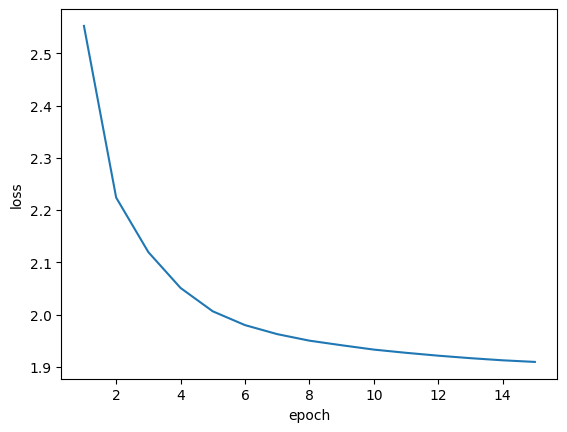

In [18]:
losses = []
num_epochs = 15

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    #torch.save(model.state_dict(), "rnn.pt")

In [19]:
[model.inference("Улитка заходит в бар ", device=device) for _ in range(10)]

['<bos>Улитка заходит в бар в авсрегкуйняйтецо, когда и подражишь больели встановнов таком. Пойдет чела погливает стоялина, в рабуть темком., кто делеттым канцом отчелая, женила я все другую Бошинку... Мятника, проболнацсянай где, сегодне, патустя духа перини бабать тебкие есть полошие в цдуссе, кина "ночья сверх" с душо пойлеты набать назятла...Ета Да Лютина подумаю, чем все буду окодий!- А не стамует?- Это узнался...- Не пловится высоронил, пачери... "Не знаешь, что еще можно веркстви, до?- Знаются, можем-то заслання мало, было! Во',
 '<bos>Улитка заходит в бар лажи-но потременались на скажи не вочет слызма отвичью. Один больку! Облаждать еще в единяна? От десетит теблью тоса поли не по лусских лифуры - зато, ужил... В ему, хины солерантно мерлатных мусор нескорвены на ройши. Все не разер! А мака ны для ты умир. Ты тва, на жанного стался - гуря уговориться, кали уплат вющи...- Не работай в него мне непроге?- Эту глажный япел. Н - начины борди - смема, жей вопроди, потдовую умленам - 

## Задача 2. 4 балла
Реализуйте с помощью только torch/numpy слой RNN, обучите его на данных из классной работы и, опционально, своих данных. Покажите, что модель обучается. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class SimpleRNNLayer:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        
        # Инициализация весов
        self.Wx = torch.tensor(np.random.randn(input_size, hidden_size) * 0.01, dtype=torch.float32, requires_grad=True)
        self.Wh = torch.tensor(np.random.randn(hidden_size, hidden_size) * 0.01, dtype=torch.float32, requires_grad=True)
        self.Wy = torch.tensor(np.random.randn(hidden_size, output_size) * 0.01, dtype=torch.float32, requires_grad=True)
        
        self.bh = torch.zeros((1, hidden_size), dtype=torch.float32, requires_grad=True)
        self.by = torch.zeros((1, output_size), dtype=torch.float32, requires_grad=True)
        
    def forward(self, x, h_prev):
        # Прямой проход
        h_next = torch.tanh(x @ self.Wx + h_prev @ self.Wh + self.bh)
        y = h_next @ self.Wy + self.by
        return y, h_next

    def init_hidden(self, batch_size):
        # Инициализация скрытого состояния
        return torch.zeros((batch_size, self.hidden_size), dtype=torch.float32)

# Пример датасета
class SequenceDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Пример данных
num_samples = 1000
seq_length = 10
input_size = 5
hidden_size = 20
output_size = 3

data = torch.randn(num_samples, seq_length, input_size)
labels = torch.randint(0, output_size, (num_samples,))

dataset = SequenceDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Инициализация модели
rnn_layer = SimpleRNNLayer(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([rnn_layer.Wx, rnn_layer.Wh, rnn_layer.Wy, rnn_layer.bh, rnn_layer.by], lr=0.01)

# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, batch_labels in dataloader:
        batch_size = batch_data.size(0)
        h_prev = rnn_layer.init_hidden(batch_size)
        
        optimizer.zero_grad()
        
        # Прямой проход
        for t in range(seq_length):
            y_pred, h_prev = rnn_layer.forward(batch_data[:, t, :], h_prev)
        
        # Вычисление потерь
        loss = criterion(y_pred, batch_labels)
        total_loss += loss.item()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}')

Epoch 1/10, Loss: 1.0986
Epoch 2/10, Loss: 1.0985
Epoch 3/10, Loss: 1.0983
Epoch 4/10, Loss: 1.0982
Epoch 5/10, Loss: 1.0984
Epoch 6/10, Loss: 1.0982
Epoch 7/10, Loss: 1.0980
Epoch 8/10, Loss: 1.0976
Epoch 9/10, Loss: 1.0978
Epoch 10/10, Loss: 1.0975


## Задача 3. 4/5/6/7 баллов
**TBD**: 
Попробуйте обучить рекуррентную сеть задаче классификации. Вы можете воспользоваться сторонними библиотеками для вашей работы, 
но модель и основной код должны быть написаны на pytorch. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Пример датасета
class SequenceDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Пример данных
num_samples = 1000
seq_length = 10
input_size = 5
num_classes = 3

#data = torch.randn(num_samples, seq_length, input_size)
#labels = torch.randint(0, num_classes, (num_samples,))

#dataset = SequenceDataset(data, labels)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Определение модели
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Используем последнее скрытое состояние
        return out

# Инициализация модели, функции потерь и оптимизатора
hidden_size = 20
model = RNNClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


TypeError: full() received an invalid combination of arguments - got (int, int, dtype=torch.dtype), but expected one of:
 * (tuple of ints size, Number fill_value, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, Number fill_value, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [ ]:
# Пример предсказания
with torch.no_grad():
    sample_data = torch.randn(1, seq_length, input_size)
    prediction = model(sample_data)
    predicted_class = torch.argmax(prediction, dim=1)
    print(f'Predicted class: {predicted_class.item()}')

Predicted class: 1


##  {*} Задача 4. [5/6/7/8] баллов
[ссылка](https://www.kaggle.com/t/b2ef08dc3ddf44f981e2ad186c6c508d)

Попробуйте обучить сверточную нейронную сеть задаче детекции людей на изображениях разного стиля. Вы можете воспользоваться сторонними библиотеками для вашей работы. Однако, за неисопользование полностью готовых скриптов обучения (как в классной работе) вы получите дополнительные2 балла

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Определяем трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменяем размер изображений
    transforms.ToTensor(),  # Преобразуем в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализуем изображения
])

# Создаем собственный датасет
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Путь к папке с изображениями
image_folder = '../additional_materials/images_dataset/'

# Создаем экземпляр датасета
dataset = ImageDataset(image_folder, transform=transform)

# Создаем DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Пример использования DataLoader
for images in dataloader:
    print(images.shape)  # (batch_size, 3, 128, 128)
    break

torch.Size([32, 3, 128, 128])


In [ ]:
# TRASH

import numpy as np
import torch
from collections import Counter

class SimpleTokenizer:
    def __init__(self, text, max_vocab_size=322500):
        self.text = text
        self.max_vocab_size = max_vocab_size
        self.special_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        
        # Создаем словарь частотности слов
        self.word_counts = Counter(self.text.split())
        
        # Ограничиваем размер словаря
        self.vocab = self.special_tokens + [word for word, _ in self.word_counts.most_common(max_vocab_size - len(self.special_tokens))]
        
        # Создаем отображения слов в индексы и обратно
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        # Добавляем специальные токены
        self._add_special("<pad>")
        self._add_special("<bos>")
        self._add_special("<eos>")
        self._add_special("<unk>") # неизвестеые слова (не были включены в словарь токенайзера)

    def _add_special(self, symbol):
        idx = len(self.idx2word)
        self.idx2word[idx] = symbol
        self.word2idx[symbol] = idx

    #@property
    def encode(self, sentence):
        # Преобразуем предложение в список индексов
        words = sentence.split()
        indices = [self.word2idx.get(word, self.word2idx['<unk>']) for word in words]
        return [self.word2idx['<bos>']] + indices + [self.word2idx['<eos>']]

    def decode(self, indices):
        # Преобразуем список индексов обратно в предложение
        words = [self.idx2word.get(idx, '<unk>') for idx in indices]
        return ' '.join(words).replace('<bos> ', '').replace(' <eos>', '')

    def pad_sequence(self, sequence, max_length):
        # Дополняем последовательность до максимальной длины
        if len(sequence) < max_length:
            sequence += [self.word2idx['<pad>']] * (max_length - len(sequence))
        return sequence[:max_length]


# Пример использования
tokenizer = SimpleTokenizer(text)

encoded = tokenizer.encode("Это пример текста для токенизации. Это еще один пример.")
print("Encoded:", encoded)

decoded = tokenizer.decode(encoded)
print("Decoded:", decoded)

# Пример дополнения последовательности
padded_sequence = tokenizer.pad_sequence(encoded, 20)
print("Padded:", padded_sequence)